
# **CONTACT ANGLE CALCULATOR**
A code designed to analyze wetting behaviors by quantifying interface deformations resulting from particle-interface interactions.

Sheyda, June 2024






# Summary

Consider a liquid-gas interface onto which a particle is placed; the objective is to observe and analyze the resulting interactions and deformations of the interface.

In this code, we utilize the output files generated from a previously conducted Lattice Boltzmann (LB) fluid simulation. By using visualization tools like ParaView, we can select all fluid data points contoured at a density of 1, which represents the interface, as it corresponds to the critical density of liquid-gas phase coexistence. Without any interference, this interface would form a flat plane, but the presence of a particle interacting with the fluid causes deformations on the interface. The goal of this notebook is to find the contact angle through analysis of the deformities.

This goal is achieved through the following steps:

1. **Receiving Interface Data:** Two .csv data files are being sed by this notebook.

> **a.** TEST FILE: A 2D slice of the simulation box capturing a side profile of the interface (contoure at the density of the interface). This 2D interpolation is only to test the accuracy of `scipy.interpolate` library for our problem.

> **b.** MAIN FILE: A 3D coordinate of the interface capturing all the points on the interface.
   
2. **Interpolating Additional Data Points/Fitting Known Funstions to the Dataset:** The notebook interpolates more data points onto the interface points to smooth out gaps in the discrete data to increase the resolution and mimic a continuous fluid.

3. **Finding a Plane as the Reference of the Non-deformed Interface:** Using a subset of data points that are far away from the wetting area, we can define our neutral interface.

4. **Defining a Threshold for Deformity of the Interface:** Set a distance range from the interface that includes the furthest data points that are affected by the wetting phenomena.

4. **Finding the Cross Section of Contact Between the Particle and the Interface:** Select a set points close enough to the particle surface that represent the touching point between the particle and the interface.

5. **Calculating Contact Angles:** Based on the selected data points and relying on the geometry of the wetting, the notebook calculates the contact angle.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from scipy import interpolate
from scipy.interpolate import griddata
import scipy.linalg
from scipy.optimize import curve_fit

# from lmfit import Model
# from lmfit.models import GaussianModel, ConstantModel, SkewedGaussianModel
# import lmfit
# from lmfit.lineshapes import gaussian2d, lorentzian

# **2D Interpolation**


In [ ]:
sl = pd.read_csv('2d_slice_contour_at_interface.csv')
sl

,Point ID,density,Normals_0,Normals_1,Normals_2,Normals_Magnitude,Points_0,Points_1,Points_2,Points_Magnitude,velocity_0,velocity_1,velocity_2,velocity_Magnitude
0,42,1,0.000172,-0.001790,0.999998,1,-48.0,0,-1.30149,48.0176,-0.000009,3.317600e-07,0.000006,0.000010
1,43,1,0.000172,-0.001790,0.999998,1,-48.0,0,-1.30149,48.0176,-0.000009,3.317600e-07,0.000006,0.000010
2,44,1,0.000374,-0.001797,0.999998,1,-47.0,0,-1.30164,47.0180,0.000015,3.895800e-07,0.000006,0.000016
3,45,1,0.000374,-0.001797,0.999998,1,-47.0,0,-1.30164,47.0180,0.000015,3.895800e-07,0.000006,0.000016
4,46,1,0.000778,-0.001806,0.999998,1,-46.0,0,-1.30215,46.0184,0.000039,4.555750e-07,0.000005,0.000040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,212,1,-0.000834,-0.001778,0.999998,1,46.0,0,-1.30225,46.0184,-0.000057,2.154760e-07,0.000005,0.000057
213,213,1,-0.000834,-0.001778,0.999998,1,46.0,0,-1.30225,46.0184,-0.000057,2.154760e-07,0.000005,0.000057
214,214,1,-0.000430,-0.001784,0.999998,1,47.0,0,-1.30169,47.0180,-0.000033,2.692710e-07,0.000006,0.000033
215,215,1,-0.000430,-0.001784,0.999998,1,47.0,0,-1.30169,47.0180,-0.000033,2.692710e-07,0.000006,0.000033


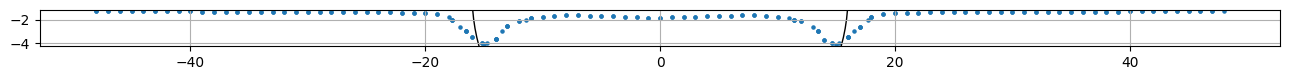

In [ ]:

x = sl['Points_0']
yn = sl['Points_2']

figure, axes = plt.subplots(figsize = (16, 4))

axes.scatter(x, yn, s=5)

circle = plt.Circle((0,0), 16, fill = False)

axes.set_aspect(1)
axes.add_artist(circle)

axes.grid()

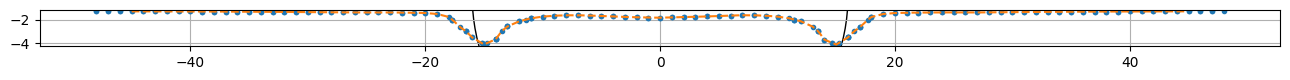

In [ ]:

xnew = np.arange(-45, 45, 0.2)
temp = interpolate.interp1d(x, yn, axis=0, fill_value="extrapolate")
ynew = temp(xnew)

figure, axes = plt.subplots(figsize = (16, 4))

circle = plt.Circle((0,0), 16, fill = False)

axes.set_aspect(1)
axes.add_artist(circle)

axes.grid()
axes.plot(x, yn, '.', xnew, ynew, '--')


It seems like the interpolation is working fine!

# **3D Interpolation**


In [ ]:
df = pd.read_csv('3d_contour_at_interface.csv')
df

,Point ID,density,Normals_0,Normals_1,Normals_2,Normals_Magnitude,Points_0,Points_1,Points_2,Points_Magnitude,velocity_0,velocity_1,velocity_2,velocity_Magnitude
0,1962,1,0.000031,1.991100e-02,0.999802,1,-48.0,-20.0,-1.008290,52.0098,4.012080e-06,1.932150e-04,-4.723590e-08,0.000193
1,2059,1,0.000085,3.337700e-02,0.999443,1,-48.0,-19.0,-1.032750,51.6340,4.113960e-06,1.966620e-04,1.549590e-08,0.000197
2,2156,1,0.000120,5.100960e-02,0.998698,1,-48.0,-18.0,-1.072860,51.2752,4.123270e-06,1.976680e-04,1.515610e-06,0.000198
3,2262,1,0.000150,5.745230e-02,0.998348,1,-48.0,-17.0,-1.129920,50.9340,2.924100e-06,1.945900e-04,6.870960e-06,0.000195
4,2358,1,0.000174,4.684830e-02,0.998902,1,-48.0,-16.0,-1.180490,50.6102,7.964820e-07,1.875080e-04,1.112660e-05,0.000188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10038,9810,1,0.000003,-7.121670e-05,1.000000,1,48.0,44.0,-0.940418,65.1221,1.145910e-06,-2.064910e-05,8.014710e-06,0.000022
10039,9868,1,-0.000002,-7.157860e-05,1.000000,1,48.0,45.0,-0.940322,65.8019,1.004120e-06,-1.537970e-05,8.073950e-06,0.000017
10040,9926,1,0.000012,-3.496410e-05,1.000000,1,48.0,46.0,-0.940277,66.4897,1.072410e-06,-1.005590e-05,8.114680e-06,0.000013
10041,9984,1,-0.000012,-2.314660e-07,1.000000,1,48.0,47.0,-0.940253,67.1854,9.877140e-07,-4.783860e-06,8.138320e-06,0.000009


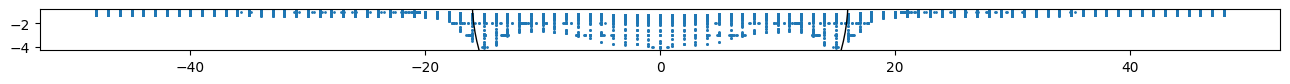

In [ ]:
figure, axes = plt.subplots(figsize = (16, 4))
plt.scatter(df['Points_1'], df['Points_2'], s=1)


circle = plt.Circle((0,0), 16, fill = False)

axes.set_aspect(1)
axes.add_artist(circle)
plt.show()


In [ ]:
X, Y = df['Points_0'], df['Points_1']
Z = df['Points_2']


This cell performs a 3D interpolation on a set of data points defined by the coordinates `X`, `Y`, and their corresponding values `Z`. It begins by creating a grid of `num = 1000` points using `np.meshgrid`.

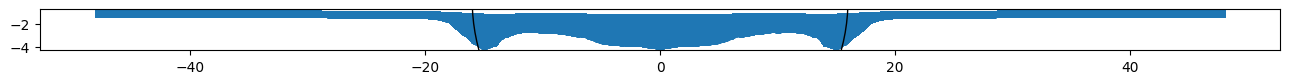

In [ ]:


num = 1000

x_coords = X
y_coords = Y
values = Z

# define the grid where we want to interpolate the surface
grid_x, grid_y = np.meshgrid(np.linspace(min(x_coords), max(x_coords), num),
                             np.linspace(min(y_coords), max(y_coords), num))

# create a tuple of the data points
data_points = np.column_stack((x_coords, y_coords))

# perform the interpolation using griddata
grid_z = griddata(data_points, values, (grid_x, grid_y), method='linear')


figure, axes = plt.subplots(figsize = (16, 4))
plt.scatter(grid_x, grid_z, s=1)


circle = plt.Circle((0,0), 16, fill = False)

axes.set_aspect(1)
axes.add_artist(circle)
plt.show()

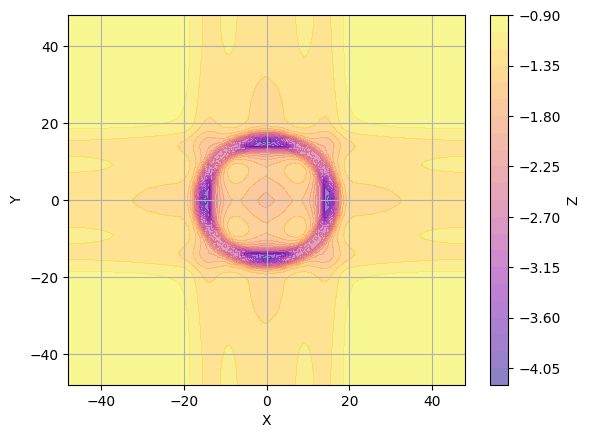

1000


In [ ]:
# plot the interpolated interface from top view

plt.contourf(grid_x, grid_y, grid_z, levels=30, cmap='plasma', alpha=0.5)
plt.colorbar(label='Z')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

print(len(grid_z))

In [ ]:
# prep the data to perform further analysis

x = grid_x.flatten()
y = grid_y.flatten()
z = grid_z.flatten()

df = pd.DataFrame()

df['x'] = x.tolist()
df['y'] = y.tolist()
df['z'] = z.tolist()

df

,x,y,z
0,-48.000000,-48.0,-0.940277
1,-47.903904,-48.0,-0.940277
2,-47.807808,-48.0,-0.940277
3,-47.711712,-48.0,-0.940276
4,-47.615616,-48.0,-0.940276
...,...,...,...
999995,47.615616,48.0,-0.940269
999996,47.711712,48.0,-0.940271
999997,47.807808,48.0,-0.940273
999998,47.903904,48.0,-0.940275


In [ ]:
# add two columns noting the distance of the point from
# the approximate center of the particle n xy plane and in 3D

df['square'] = df['x']**2 + df['y']**2
df['radius^2'] = df['square'] + df['z']**2

df

,x,y,z,square,radius^2
0,-48.000000,-48.0,-0.940277,4608.000000,4608.884121
1,-47.903904,-48.0,-0.940277,4598.784009,4599.668130
2,-47.807808,-48.0,-0.940277,4589.586487,4590.470608
3,-47.711712,-48.0,-0.940276,4580.407434,4581.291554
4,-47.615616,-48.0,-0.940276,4571.246850,4572.130970
...,...,...,...,...,...
999995,47.615616,48.0,-0.940269,4571.246850,4572.130955
999996,47.711712,48.0,-0.940271,4580.407434,4581.291543
999997,47.807808,48.0,-0.940273,4589.586487,4590.470600
999998,47.903904,48.0,-0.940275,4598.784009,4599.668126


In [ ]:
# remove points around and inside the particle (selecting points not affected by wetting)
# this plane will be the reference of the non-deformed interface

plane = df.loc[df['square'] > 25**2]
plane = plane.reset_index(drop=True)
plane

,x,y,z,square,radius^2
0,-48.000000,-48.0,-0.940277,4608.000000,4608.884121
1,-47.903904,-48.0,-0.940277,4598.784009,4599.668130
2,-47.807808,-48.0,-0.940277,4589.586487,4590.470608
3,-47.711712,-48.0,-0.940276,4580.407434,4581.291554
4,-47.615616,-48.0,-0.940276,4571.246850,4572.130970
...,...,...,...,...,...
787379,47.615616,48.0,-0.940269,4571.246850,4572.130955
787380,47.711712,48.0,-0.940271,4580.407434,4581.291543
787381,47.807808,48.0,-0.940273,4589.586487,4590.470600
787382,47.903904,48.0,-0.940275,4598.784009,4599.668126


(-48.0, 48.0)

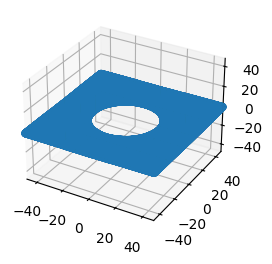

In [ ]:
# 3d plot of the points

fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.scatter(plane['x'], plane['y'], plane['z'], alpha=0.2)


plt.xlim(-48, 48)
plt.ylim(-48, 48)
ax.axes.set_zlim3d(bottom=-48, top=48)



First, the code extracts the x, y, and z coordinates from the dataset `plane_test` and stores them in three separate lists. These points are then plotted in a 3D scatter plot using `matplotlib`, where each point is displayed as a blue dot.

Next, the fitting process begins. The idea is to find a plane equation of the form `ax + by + c = z` that best fits the given points. To do this, the code constructs two matrices: `A`, which holds the x and y coordinates (with a constant term for the intercept), and `b`, which holds the z coordinates. It then solves the least squares problem to find the best-fitting parameters for `a`, `b`, and `c`. The manual solution uses linear algebra (`(A.T * A).I * A.T * b`) to compute the parameters, and the residual error is calculated as the difference between the actual z values and the values predicted by the fitted plane.

Once the plane is fitted, the code prints the equation of the plane in the form `a * x + b * y - z + c = 0`, showing the computed coefficients. Finally, it visualizes the fitted plane by generating a grid of x and y values, calculating the corresponding z values using the plane equation, and plotting the wireframe of the plane in the same 3D space as the scatter plot of the original points. The 3D plot is labeled, and the axis limits are set to maintain consistency with the coordinate range of the data.


<ipython-input-15-caf22e03cc53>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("solution: %f x + %f y - z + %f = 0" % (fitp[0], fitp[1], fitp[2]))
<ipython-input-15-caf22e03cc53>:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[r,c] = fitp[0] * X[r,c] + fitp[1] * Y[r,c] + fitp[2]


solution: 0.000006 x + 0.000000 y - z + -1.115397 = 0


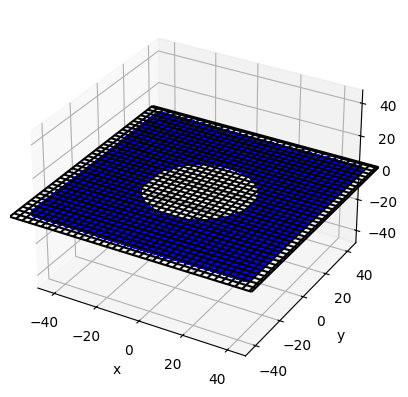

In [ ]:
plane_test = plane

# set of points as a list
xs = list(plane_test['x'])
ys = list(plane_test['y'])
zs = list(plane_test['z'])


# plot raw data
# plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(xs, ys, zs, color='b')

# do fit
tmp_A = []
tmp_b = []
for i in range(len(xs)):
    tmp_A.append([xs[i], ys[i], 1])
    tmp_b.append(zs[i])
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)

# manual solution

fitp = (A.T * A).I * A.T * b
errors = b - A * fitp
residual = np.linalg.norm(errors)

# scipy

# from scipy.linalg import lstsq
# fit, residual, rnk, s = lstsq(A, b)

print("solution: %f x + %f y - z + %f = 0" % (fitp[0], fitp[1], fitp[2]))
# print("errors: \n", errors)
# print("residual:", residual)

# plot plane
xlim = ax.get_xlim()
ylim = ax.get_ylim()
X,Y = np.meshgrid(np.arange(xlim[0], xlim[1]),
                  np.arange(ylim[0], ylim[1]))
Z = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = fitp[0] * X[r,c] + fitp[1] * Y[r,c] + fitp[2]
ax.plot_wireframe(X,Y,Z, color='k')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.xlim(-48, 48)
plt.ylim(-48, 48)
ax.axes.set_zlim3d(bottom=-48, top=48)

plt.show()

In [ ]:
len(plane['x'])

787384

In [ ]:
# remove any interface plane points indside the particle

df = df.loc[df['radius^2'] > 16**2]
df = df.reset_index(drop=True)

This cell selects two set of points that are placed within a certain distance range from the fitted plane.

In [ ]:
# this cell might take long, let it run


# deviation circle at the top
index_listtop = []

for i in range(0, len(df['x'])):
    numerator = abs((fitp[0]* df['x'][i] + fitp[1]* df['y'][i] - df['z'][i] + fitp[2]))
    denominator = math.sqrt(fitp[0]**2 +  fitp[1]**2 + 1 )
    dist = numerator / denominator
    if (dist > 0.5 and dist < 0.75):
        index_listtop.append(i)

# contact circle at the bottom
index_listbot = []

for i in range(0, len(df['x'])):
    numerator = abs((fitp[0]* df['x'][i] + fitp[1]* df['y'][i] - df['z'][i] + fitp[2]))
    denominator = math.sqrt(fitp[0]**2 +  fitp[1]**2 + 1 )
    dist = numerator / denominator
    if (dist > 1.5 and dist < 1.75):
        index_listbot.append(i)

<ipython-input-18-407c570872e9>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denominator = math.sqrt(fitp[0]**2 +  fitp[1]**2 + 1 )
<ipython-input-18-407c570872e9>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denominator = math.sqrt(fitp[0]**2 +  fitp[1]**2 + 1 )


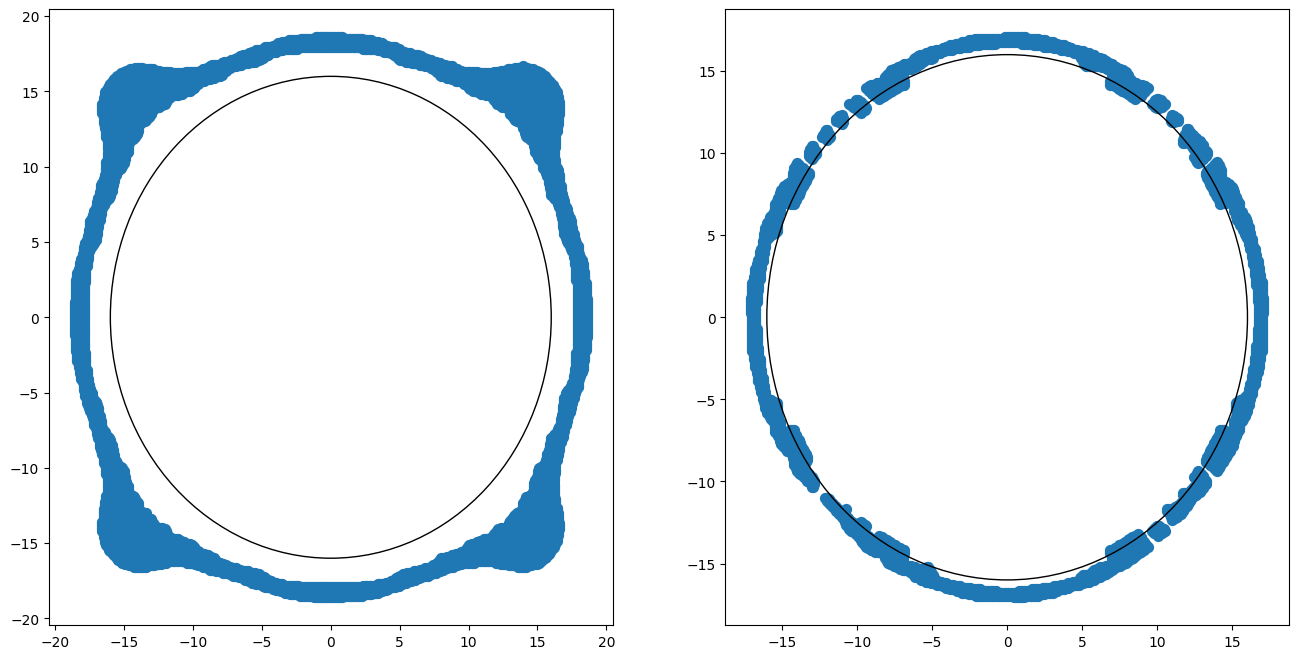

In [ ]:
newdftop = df[df.index.isin(index_listtop)]
newdftop = newdftop.reset_index(drop=True)

newdfbot = df[df.index.isin(index_listbot)]
newdfbot = newdfbot.reset_index(drop=True)


fig, ax = plt.subplots(1, 2, figsize=(16, 8))

circle1 = plt.Circle((0,0), 16, fill = False)
ax[0].scatter(newdftop['x'], newdftop['y'], s=50)
ax[0].add_artist(circle1)

circle2 = plt.Circle((0,0), 16, fill = False)
ax[1].scatter(newdfbot['x'], newdfbot['y'], s=50)
ax[1].add_artist(circle2)

To get a perfect circular shape for the cross section of the particle and interface, we need to remove the corners that are merely an artifact of dicretization that appears in the anisotropy of the velocity field.

(This step hopefully is not ndeeded after we add the b-terms and get rid of spurious currents!)

In [ ]:
newdftop = newdftop.loc[newdftop['square'] < 19**2]
newdftop = newdftop.reset_index(drop=True)
newdftop

,x,y,z,square,radius^2
0,-1.201201,-18.594595,-1.615870,347.201832,349.812868
1,-1.105105,-18.594595,-1.617324,346.980205,349.595942
2,-1.009009,-18.594595,-1.618778,346.777047,349.397489
3,-0.912913,-18.594595,-1.619653,346.592358,349.215633
4,-0.816817,-18.594595,-1.620467,346.426138,349.052053
...,...,...,...,...,...
7527,0.432432,18.594595,-1.621044,345.945946,348.573729
7528,0.528529,18.594595,-1.619866,346.038291,348.662255
7529,0.624625,18.594595,-1.618669,346.149104,348.769192
7530,0.720721,18.594595,-1.617430,346.278386,348.894466


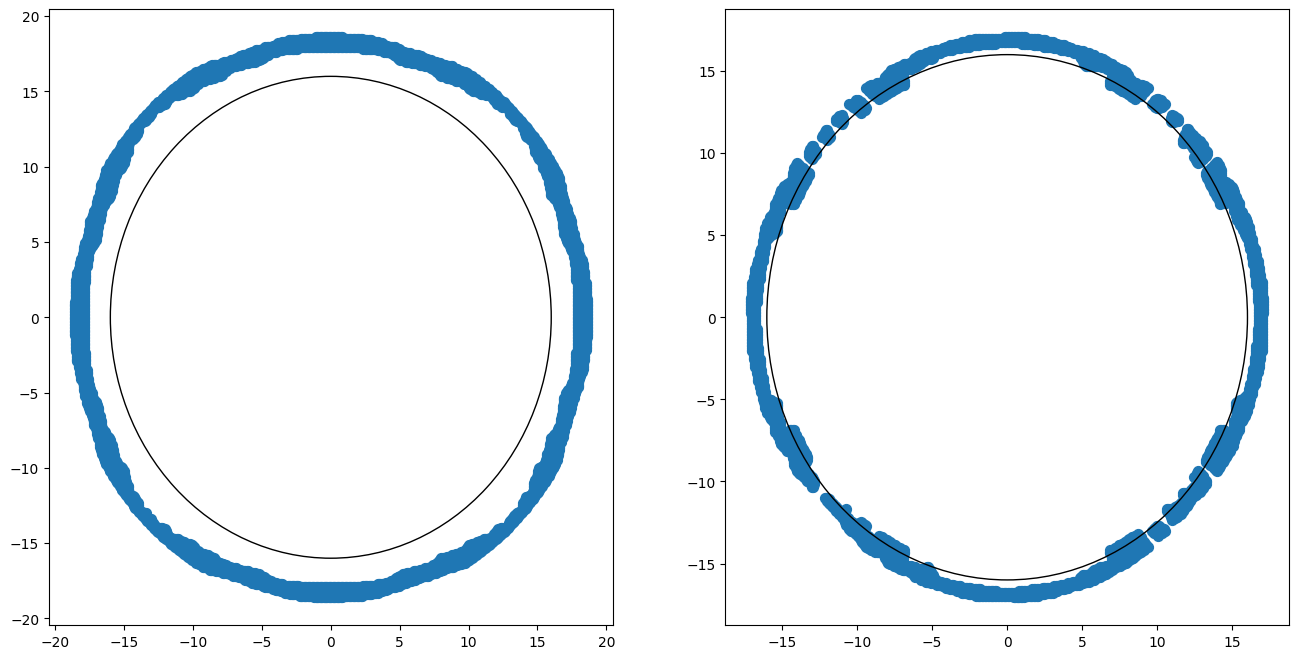

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

circle1 = plt.Circle((0,0), 16, fill = False)
ax[0].scatter(newdftop['x'], newdftop['y'], s=50)
ax[0].add_artist(circle1)

circle2 = plt.Circle((0,0), 16, fill = False)
ax[1].scatter(newdfbot['x'], newdfbot['y'], s=50)
ax[1].add_artist(circle2)

In [ ]:
# fitting the circle
print('For the top circle (deviation circle):\n')

z_top = newdftop['z'].mean()
r_top = math.sqrt(np.mean(newdftop['x']**2 + newdftop['y']**2))

print('z =', z_top)
print('r =', r_top)

print('\nFor the bottom circle ():\n')

z_bot = newdfbot['z'].mean()
r_bot = math.sqrt(np.mean(newdfbot['x']**2 + newdfbot['y']**2))

print('z =', z_bot)
print('r =', r_bot)

For the bigger circle:

z = -1.7382573744870484
r = 18.42008690928551

For the smaller circle:

z = -2.7265137583995043
r = 16.54491860565423


In [ ]:
zp = abs(z_bot - z_top)
rp = abs(r_bot - r_top)

gammap = abs(np.arctan(r_bot/z_bot))
alphap = np.arctan(rp/zp)

angp = np.pi - gammap - alphap

print('wetting angle =', angp*180/np.pi)

wetting angle = 37.14818116686493


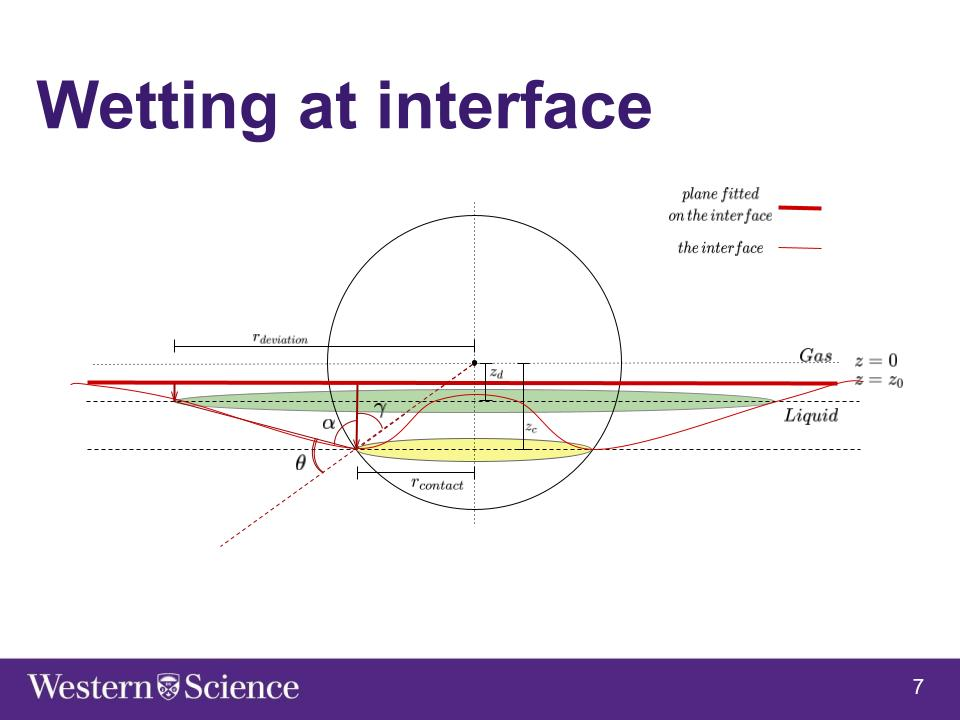